#Term Deposit Subscription Prediction

The objective is to predict whether a bank client will subscribe to a term deposit (yes/no) using Logistic Regression.
Since the dataset is imbalanced and business costs of errors differ, accuracy alone is insufficient.
False Positives → marketing resources wasted
False Negatives → loss of potential customers
Hence, evaluation focuses on Precision, Recall, F1-score, ROC-AUC, Sensitivity, and Specificity.

###Why Logistic Regression?
Suitable for binary classification
Outputs probabilities, enabling threshold tuning
Interpretable and widely used in banking systems

###Why ROC Curve is Useful?
The ROC curve shows the trade-off between:
True Positive Rate (Sensitivity)
False Positive Rate
It evaluates the model across all thresholds, making it robust to class imbalance.
ROC-AUC measures the model’s overall discriminative ability, independent of any fixed threshold.

###Effect of Changing Threshold
Lower threshold → higher Recall, lower Precision
Higher threshold → higher Precision, lower Recall
Thus, threshold selection depends on business priorities, not just accuracy.

In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

bank_data = fetch_ucirepo(id=222)

X_raw = bank_data.data.features
y_raw = bank_data.data.targets
print(bank_data.variables)
df = pd.concat([X_raw, y_raw], axis=1)
df = df.rename(columns={'y': 'subscribed'})


           name     role         type      demographic  \
0           age  Feature      Integer              Age   
1           job  Feature  Categorical       Occupation   
2       marital  Feature  Categorical   Marital Status   
3     education  Feature  Categorical  Education Level   
4       default  Feature       Binary             None   
5       balance  Feature      Integer             None   
6       housing  Feature       Binary             None   
7          loan  Feature       Binary             None   
8       contact  Feature  Categorical             None   
9   day_of_week  Feature         Date             None   
10        month  Feature         Date             None   
11     duration  Feature      Integer             None   
12     campaign  Feature      Integer             None   
13        pdays  Feature      Integer             None   
14     previous  Feature      Integer             None   
15     poutcome  Feature  Categorical             None   
16            

In [4]:
type(X_raw), type(y_raw)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [5]:
df.shape

(45211, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  subscribed   45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Class Distribution Analysis

In [8]:
print("\nClass distribution:")
print(df['subscribed'].value_counts())
print("\nClass distribution (%):")
print(df['subscribed'].value_counts(normalize=True) * 100)


Class distribution:
subscribed
no     39922
yes     5289
Name: count, dtype: int64

Class distribution (%):
subscribed
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


In [9]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day_of_week,int64


In [10]:
df.isnull().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


Missing Value Treatment and Target Encoding

In [11]:
categorical_columns = df.select_dtypes(include='object').columns
df[categorical_columns] = df[categorical_columns].fillna('unknown')

df['subscribed'] = df['subscribed'].map({'yes': 1, 'no': 0})

Age vs Subscription

In [12]:
df.groupby('subscribed')['age'].mean()

,age
subscribed,
0,40.838986
1,41.670070


Balance vs Subscription

In [13]:
df.groupby('subscribed')['balance'].median()

,balance
subscribed,
0,417.0
1,733.0


Subscription Rate by Job

In [14]:
job_sub_rate = (df.groupby('job')['subscribed'].mean().sort_values(ascending=False))
print(job_sub_rate)

job
student          0.286780
retired          0.227915
unemployed       0.155027
management       0.137556
admin.           0.122027
self-employed    0.118429
unknown          0.118056
technician       0.110570
services         0.088830
housemaid        0.087903
entrepreneur     0.082717
blue-collar      0.072750
Name: subscribed, dtype: float64


Subscription Rate by Education

In [15]:
edu_sub_rate = (df.groupby('education')['subscribed'].mean().sort_values(ascending=False))
print(edu_sub_rate)

education
tertiary     0.150064
unknown      0.135703
secondary    0.105594
primary      0.086265
Name: subscribed, dtype: float64


Housing Loan Impact

In [16]:
df.groupby('housing')['subscribed'].mean()

,subscribed
housing,
no,0.167024
yes,0.077000


Contact Method Effectiveness

In [17]:
df.groupby('contact')['subscribed'].mean()

,subscribed
contact,
cellular,0.149189
telephone,0.134205
unknown,0.040707


Duration

In [18]:
df.groupby('subscribed')['duration'].mean()

,duration
subscribed,
0,221.182806
1,537.294574


Number of Contacts

In [19]:
df.groupby('subscribed')['campaign'].mean()

,campaign
subscribed,
0,2.846350
1,2.141047


Correlation Analysis

In [20]:
num_features = X_raw.select_dtypes(include='int64').columns
cat_features = X_raw.select_dtypes(include='object').columns

correlation_matrix = df[list(num_features) + ['subscribed']].corr()

correlation_matrix['subscribed'].sort_values(ascending=False)

,subscribed
subscribed,1.000000
duration,0.394521
pdays,0.103621
previous,0.093236
balance,0.052838
age,0.025155
day_of_week,-0.028348
campaign,-0.073172


Split Features and Target

In [21]:
X = df.drop('subscribed', axis=1)
y = df['subscribed']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


Identify Feature Types

In [23]:
num_cols = X.select_dtypes(include=['int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

Preprocessing Transformer

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

Model Pipeline and Training

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logistic_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logistic_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

Prediction Using Default Threshold (0.5)

In [26]:
y_prob = logistic_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

Confusion Matrix and Metrics

In [27]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

cm = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

cm, precision, recall, f1, roc_auc


(array([[9723,  258],
        [ 857,  465]]),
 0.6431535269709544,
 0.3517397881996974,
 0.4547677261613692,
 np.float64(0.906139971543512))

Sensitivity and Specificity

In [28]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

sensitivity, specificity

(np.float64(0.3517397881996974), np.float64(0.974150886684701))

ROC Curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

fpr[:5], tpr[:5], thresholds[:5]


(array([0.        , 0.00010019, 0.00010019, 0.00030057, 0.00030057]),
 array([0.        , 0.        , 0.00075643, 0.00075643, 0.00529501]),
 array([       inf, 0.99999504, 0.9999184 , 0.99890263, 0.99675913]))

Find Optimal Threshold

In [30]:
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

optimal_threshold

np.float64(0.11174812194665963)

Metrics at Optimized Threshold

In [31]:
y_pred_opt = (y_prob >= optimal_threshold).astype(int)

cm_opt = confusion_matrix(y_test, y_pred_opt)

precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)

tn, fp, fn, tp = cm_opt.ravel()
specificity_opt = tn / (tn + fp)

cm_opt, precision_opt, recall_opt, f1_opt, specificity_opt

(array([[8349, 1632],
        [ 207, 1115]]),
 0.40589734255551513,
 0.8434190620272315,
 0.5480462029982797,
 np.float64(0.8364893297264803))

Plot ROC Curve

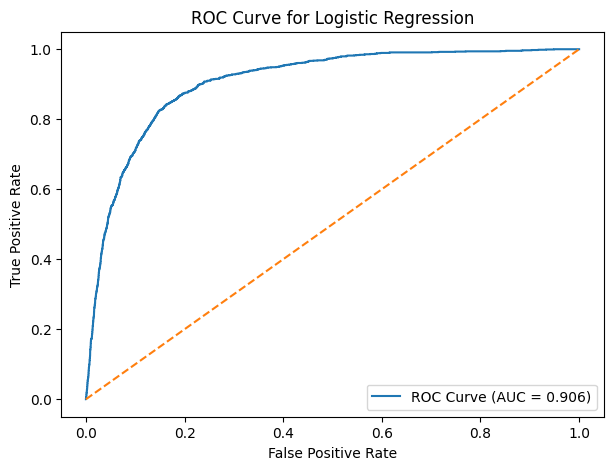

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()


Export Probabilities File

In [33]:
probability_output = pd.DataFrame({
    'RecordId': X_test.index,
    'Probability_yes': y_prob,
    'PredictedLabel': y_pred
})

probability_output.to_csv('probabilities.csv', index=False)

probability_output.head()

,RecordId,Probability_yes,PredictedLabel
0,22684,0.029007,0
1,30384,0.104096,0
2,10483,0.035553,0
3,8732,0.008735,0
4,21614,0.064102,0
